<a href="https://colab.research.google.com/github/ChithraSivan/ADL_project-Image_Caption_generator/blob/main/basicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence,image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Embedding,BatchNormalization
from tensorflow.keras.layers import Dropout, TimeDistributed, Dense,Concatenate, RepeatVector, Activation, Input, add
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.layers.wrappers import Bidirectional
from tensorflow.keras import Input
from tqdm import tqdm_notebook as tqdm
from keras import backend 
from PIL import Image
import numpy as np
import pandas as pd
import pickle
from IPython.display import display
%matplotlib inline
from matplotlib.pyplot import imshow
from nltk.translate.bleu_score import sentence_bleu
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# load doc into memory
def load_doc(filename): 
    file = open(filename, 'r') 
    text = file.read() 
    file.close()
    return text

filename = "/content/drive/My Drive/Flickr8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)


In [ ]:
def load_descriptions(doc):
    mapping = dict()
    
    for line in doc.split('\n'):
        
        if len(line) < 2:
            continue
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        image_id = image_id.split('.')[0]
        
        image_desc = ' '.join(image_desc)
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
from nltk.tokenize import RegexpTokenizer
import string
tokenizer = RegexpTokenizer(r'\w+')

def clean_descriptions(descriptions):
    
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            
            desc = tokenizer.tokenize(desc)
            
            desc = [word.lower() for word in desc]
            
            desc = [word for word in desc if len(word)>1]
            
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [ ]:
def vocabl(descriptions):
    captions = set()
    for i in descriptions.keys():
        [captions.update(tokenizer.tokenize(d)) for d in descriptions[i]]
    return captions

vocabulary = vocabl(descriptions)


In [ ]:
def saveFile(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

saveFile(descriptions, '/content/drive/My Drive/Flickr8k_text/descriptions1.txt')


In [ ]:
# load Train Data
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt'
train_names = load_set(filename)
print('Train size: %d' % len(train_names))

Directroy_path = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'
train_img= [Directroy_path+i  for i in train_names]

Train size: 6000


In [ ]:
# Loading test data, 
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    
    for line in doc.split('\n'):
        
        if len(line) < 1:
            continue
 
        dataset.append(line)
    return (dataset)
 
filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
test_names = load_set(filename)
print('Test Size: %d' % len(test_names))

Directroy_path = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'
test_img= [Directroy_path+i  for i in test_names]

Test Size: 1000


In [ ]:
def load_clean_descriptions(filename, dataset):
    
    dataset = [i.split('.')[0] for i in dataset]
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        
        tokens = line.split()
        
        image_id, image_desc = tokens[0], tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/content/drive/My Drive/Flickr8k_text/descriptions1.txt', train_names)



In [ ]:
# Save train_descriptions
with open("/content/drive/My Drive/train_descriptions1.pkl", "wb") as encoded_pickle:
    pickle.dump(train_descriptions, encoded_pickle)

In [ ]:
def preprocess(image_path):
    # size 299*299
    img = image.load_img(image_path, target_size=(299, 299))    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)    
    x = preprocess_input(x)
    return x

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
#using pretraing weight of imageNet dataset 


model = InceptionV3(weights='imagenet')
new_input = model.input
new_output = model.layers[-1].output
model_new = Model(new_input, new_output)

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
# feture encoding
def encode(image):
    image = preprocess(image) 
    v = model_new.predict(image) 
    v = np.reshape(v, v.shape[1]) 
    return v

In [ ]:
from time import time
from tensorflow.keras.applications.inception_v3 import preprocess_input
start = time()
k=0
encoded_train = {}
for picture in tqdm(train_img):
 
    encoded_train[picture[len(Directroy_path):]] = encode(picture)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/6000 [00:00<?, ?it/s]

Time taken in seconds = 2238.203264474869


In [ ]:
# Encoding all the Test Dataset to a 2048 Dimension Vectors, Run this once
start = time()
encoded_test = {}
for picture in tqdm(test_img):
    encoded_test[picture[len(Directroy_path):]] = encode(picture)
print("Time taken in seconds =", time()-start)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1000 [00:00<?, ?it/s]

Time taken in seconds = 364.3825304508209


In [ ]:
# dump Train features
with open("/content/drive/My Drive/encoded_train_images_VGG16.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_train, encoded_pickle)

In [ ]:
# dump test features 

from pickle import dump, load
with open("/content/drive/My Drive/encoded_test_images_VGG16.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_test, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/My Drive/encoded_train_images_VGG16.pkl", "rb"))

train_descriptions = load(open("/content/drive/My Drive/train_descriptions_VGG16.pkl", "rb"))


In [ ]:
training_sentences = []
for i, vj in train_descriptions.items():
    for sent in vj:
        training_sentences.append(sent)


In [ ]:
c = {}
loop = 0
for sent in training_sentences:
    loop += 1
    for w in sent.split(' '):
        if w not in c:
            c[w] = 0
        c[w] += 1

vocab = [w for w in c if c[w] >= 7]
print('preprocessed words %d -> %d' % (len(c), len(vocab)))

preprocessed words 7350 -> 2063


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

2064

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size
# maximum length of description
def max_length(descriptions): 
    max_l = -1e9
    for key, cap in descriptions.items():
        for line in cap:
            max_l = max(max_l, len(line.split(' ')))
    return max_l

max_length = max_length(train_descriptions)


In [ ]:
import os
glove_dir = '/content/drive/My Drive/'
ind = {}
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    ind[word] = coefs
f.close()
print('Found %s word vectors.' % len(ind))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0it [00:00, ?it/s]

Found 400000 word vectors.


In [ ]:
dimen = 200

em_matrix = np.zeros((vocab_size, dimen))

for word, i in tqdm(wordtoix.items()):
    if word in ind:
        v = ind[word]
        em_matrix[i] = v

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/2063 [00:00<?, ?it/s]

In [ ]:
with open('/content/drive/My Drive/Embedding_Matrix_VGG16.pkl', 'wb') as embedding_pickle:
    pickle.dump(em_matrix, embedding_pickle)

In [ ]:
with open('/content/drive/My Drive/wordtoix_VGG16.pkl', 'wb') as wti_pickle:
    pickle.dump(wordtoix, wti_pickle)

In [ ]:
em_matrix = load(open("/content/drive/My Drive/Embedding_Matrix_VGG16.pkl", "rb"))

wordtoix = load(open("/content/drive/My Drive/wordtoix_VGG16.pkl", "rb"))


In [ ]:
max_length = 34 
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import array
from tensorflow.keras.utils import to_categorical

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, value in descriptions.items():
            n+=1
            
            photo = photos[key+'.jpg']
            for sentences in value:
              
                vocabseq = [wordtoix[word] for word in sentences.split(' ') if word in wordtoix]
                
                for i in range(1, len(vocabseq)):                    
                    in_vocabseq, out_vocabseq= vocabseq[:i], vocabseq[i]                    
                    in_vocabseq = pad_sequences([in_vocabseq], maxlen=max_length)[0]                 
                    out_vocabseq= to_categorical([out_vocabseq], num_classes=vocab_size)[0]                    
                    X1.append(photo)
                    X2.append(in_vocabseq)
                    y.append(out_vocabseq)
            # return value
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0
    return X1, X2, y

In [ ]:
max_length = 35 
vocab_size = em_matrix.shape[0]
images_per_batch = 3
steps = len(train_descriptions)//images_per_batch
dimen = em_matrix.shape[1]


In [ ]:
#Decoder architecture using LSTM , features input is 4096
inputs1 = Input(shape=(4096,))
in1 = Dropout(0.5)(inputs1)
in2 = Dense(256, activation='relu')(in1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, dimen, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
dec1 = add([in2, se3])
dec2 = Dense(256, activation='relu')(dec1)
outputs = Dense(vocab_size, activation='softmax')(dec2)
my_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:

my_model.layers[2].set_weights([em_matrix])
my_model.layers[2].trainable = False

In [ ]:
my_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
epochs = 25
images_per_batch = 6
steps = len(train_descriptions)

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, images_per_batch)
    my_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
my_model.save('/content/drive/My Drive/ShowTell_' + 'test' + '.h5')
    

   1/6000 [..............................] - ETA: 11:37 - loss: 2.7985

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 625s 104ms/step - loss: 2.0152


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('ShowTell_test.h5')

In [ ]:
images = '/content/drive/My Drive/Flicker8k_Dataset/Flicker8k_Dataset/'

In [ ]:
with open("/content/drive/My Drive/encoded_test_images_VGG16.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)
# Loading wordtoix
wordtoix = load(open("/content/drive/My Drive/wordtoix_VGG16.pkl", "rb"))
print('Wordtoix Length = %d' % len(wordtoix))

Wordtoix Length = 2063


In [ ]:
Directory_path = "/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/"

In [ ]:
def greedySearch(photo):
    caption = 'startseq'
    for i in range(max_length):
        s1 = [wordtoix[w] for w in caption.split() if w in wordtoix]
        s1 = pad_sequences([s1], maxlen=max_length)
        pred = my_model.predict([photo,s1], verbose=0)
        pred = np.argmax(pred)
        word = ixtoword[pred]
        caption += ' ' + word
        if word == 'endseq':
            break
    caption = caption.split()
    caption = caption[1:-1]
    caption = ' '.join(caption)
    return caption

In [ ]:
test_images_path = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = split_data(test_images)


In [ ]:
try_image = test_img[0]
Image.open(try_image)

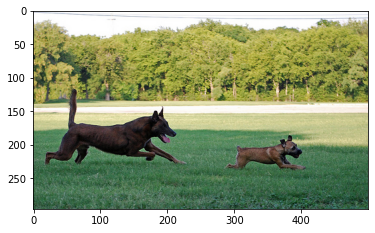

Greedy: two brown dogs are playing in the grass


In [ ]:
import matplotlib.pyplot as plt
max_length = 35
image_no= 18
image1 = list(encoding_test.keys())[image_no]
image = encoding_test[image1].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

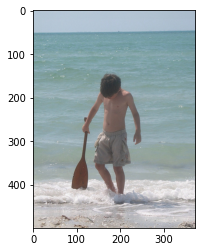

Greedy: two children are in the water with their floating in the water


In [ ]:
import matplotlib.pyplot as plt
max_length = 35
image_no= 98
image1 = list(encoding_test.keys())[image_no]
image = encoding_test[image1].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

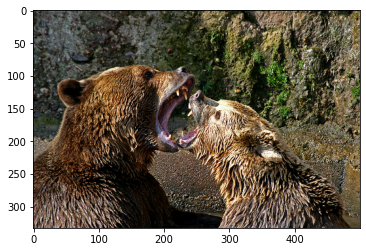

Greedy: dog is shaking its nose while standing on the grass


In [ ]:
import matplotlib.pyplot as plt
max_length = 35
image_no= 99
image1 = list(encoding_test.keys())[image_no]
image = encoding_test[image1].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

751109943_2a7f8e117f.jpg


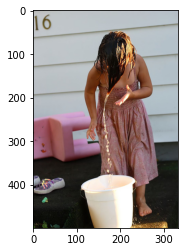

Greedy: two girls are sitting on the floor by garden


In [ ]:
import matplotlib.pyplot as plt
max_length = 35
image_no= 200
image1 = list(encoding_test.keys())[image_no]
image = encoding_test[image1].reshape((1,2048))
x=plt.imread(Directory_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
def get_bleu_score(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        key=key+".jpg"
        image = encoding_test[key].reshape((1,2048))
        yhat = greedySearch(image)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    
    # calculate the BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# load a pre-defined list of photo identifiers
def load_set1(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [ ]:
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

# loading test set
filename = '/content/drive/My Drive/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set1(filename)
print('Dataset: %d' % len(test))


test_descriptions = load_clean_descriptions('/content/drive/My Drive/descriptions.txt', test)
print('Descriptions for test: %d' % len(test_descriptions))

test_features=encoded_test
print(test_features['1056338697_4f7d7ce270.jpg'])
print('Images in test: %d' % len(test_features))

# evaluate model
get_bleu_score(my_model, test_descriptions, test_features, wordtoix, max_length)

Dataset: 1000
Descriptions for test: 1000
[0.4530928  0.25752306 0.11301478 ... 1.1222705  0.3438031  1.015096  ]
Images in test: 1000
BLEU-1: 0.395904
BLEU-1: 0.231751
BLEU-1: 0.161797
BLEU-1: 0.076995
